In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import math
from tensorflow.python.framework import ops
import warnings
import random
import os

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
logs_path = 'log_sigmoid/'
batch_size = 100
learning_rate = 0.003
training_epochs = 10
display_epoch = 1

In [3]:
dataPath = "temp/"
if not os.path.exists(dataPath):
    os.makedirs(dataPath)

mnist = input_data.read_data_sets(dataPath,one_hot=True) # MNIST to be downloaded

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting temp/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting temp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting temp/t10k-images-idx3-ubyte.gz
Extracting temp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
print(mnist.train.images.shape)
print(mnist.train.labels.shape)
print(mnist.test.images.shape)
print(mnist.test.labels.shape)

(55000, 784)
(55000, 10)
(10000, 784)
(10000, 10)


In [5]:
image_0 = mnist.train.images[0]
image_0 = np.resize(image_0, (28,28))
label_0 = mnist.train.labels[0]
print(label_0)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


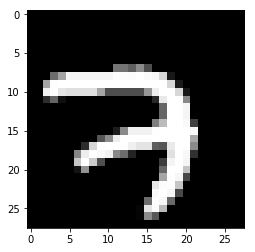

In [6]:
plt.imshow(image_0, cmap='Greys_r')
plt.show()

In [7]:
# 图像大小 28*28=784。[None, 784]表示任意行，784列
X = tf.placeholder(tf.float32, [None, 784], name = 'InputData') 

#reshape中-1表示根据另一个维度自动匹配大小。为什么这里还要reshape，上面不是已经784列的任意行了吗？
XX = tf.reshape(X, [-1, 784]) 

# 数字0-9的10个分类。Y_中放置label数据, 任意行10列
Y_ = tf.placeholder(tf.float32, [None, 10], name = 'LabelData') 

L = 200 # layer 1 的neurons数量
M = 100 # layer 2 的neurons数量
N = 60 # layer 3 的neurons数量
O = 30 # layer 4 的neurons数量

# Hidden Layer 1

# 随机初始化hidden Layer 1 的Weights。从截断的正态分布中输出随机值。stddev：正态分布的标准差
W1 = tf.Variable(tf.truncated_normal([784, L], stddev=0.1))
# Layer 1 的bias，初始化为0
B1 = tf.Variable(tf.zeros([L])) 
# Layer 1 output
Y1 = tf.nn.sigmoid(tf.matmul(XX, W1) + B1) 

# Hidden Layer 2
W2 = tf.Variable(tf.truncated_normal([L, M], stddev=0.1)) 
B2 = tf.Variable(tf.ones([M])) 
Y2 = tf.nn.sigmoid(tf.matmul(Y1, W2) + B2) 

# Hidden Layer 3
W3 = tf.Variable(tf.truncated_normal([M, N], stddev=0.1)) 
B3 = tf.Variable(tf.ones([N])) 
Y3 = tf.nn.sigmoid(tf.matmul(Y2, W3) + B3) 

# Hidden Layer 4
W4 = tf.Variable(tf.truncated_normal([N, O], stddev=0.1)) 
B4 = tf.Variable(tf.ones([O])) 
Y4 = tf.nn.sigmoid(tf.matmul(Y3, W4) + B4) 

# Layer 5 output layer . 激活函数使用softmax
W5 = tf.Variable(tf.truncated_normal([O, 10], stddev=0.1)) 
B5 = tf.Variable(tf.ones([10])) 

Ylogits = tf.matmul(Y4, W5) + B5 # logits ：未归一化的概率， 一般也就是 softmax层的输入
Y = tf.nn.softmax(Ylogits)



Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# 交叉熵损失函数，BP算法

#下面函数的返回值类型与logits相同，shapes与labels相同
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=Ylogits, labels=Y_) 

#reduce_mean, 矩阵元素求平均值，或者在一个方向上的平均值。下面得到每个样本的交叉熵均值（0到1之间）
cost_op = tf.reduce_mean(cross_entropy)*100 

# tf.argmax() 返回矩阵在行方向（第二参数为1）或列方向（第二参数为0）的最大值的索引
# 在Y和Y_中，这个正好代表列one_hot编码中为1的位置
# 再使用equal()函数，对Y和Y_每一行的hot编码进行比较。相同为True，不同为False。
# 使用cast转换类型，True为1，False为0。所以，求均值正是得到了准确度
correct_prediction = tf.equal(tf.argmax(Y,1), tf.argmax(Y_, 1)) 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

#使用优化器。Optimizer对损失函数cost_op进行最小化的优化，对Variable进行调整
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost_op)

init_op = tf.global_variables_initializer()

#创建summary用于在TensorBoard上进行监控
tf.summary.scalar("cost", cost_op)
tf.summary.scalar("accuracy", accuracy)
summary_op = tf.summary.merge_all()


In [9]:
"""
# 理解argmax()
from numpy import *
xxx = array([
    [1,2,3],
    [2,3,4],
    [5,4,3],
    [8,7,2]])

print(np.argmax(xxx,0))
print(np.argmax(xxx,1))

# 理解tf.equal(), tf.cast(), tf.reduce_mean()

import tensorflow as tf
x = [1, 3, 0, 2]
y = [1, 4, 2, 2]
equal = tf.equal(x, y)
type = tf.cast(equal, tf.float32)
with tf.Session() as sess:
    print(sess.run(equal))
    print(sess.run(type))
    print(sess.run(tf.reduce_mean(type)))
    
"""

'\n# 理解argmax()\nfrom numpy import *\nxxx = array([\n    [1,2,3],\n    [2,3,4],\n    [5,4,3],\n    [8,7,2]])\n\nprint(np.argmax(xxx,0))\nprint(np.argmax(xxx,1))\n\n# 理解tf.equal(), tf.cast(), tf.reduce_mean()\n\nimport tensorflow as tf\nx = [1, 3, 0, 2]\ny = [1, 4, 2, 2]\nequal = tf.equal(x, y)\ntype = tf.cast(equal, tf.float32)\nwith tf.Session() as sess:\n    print(sess.run(equal))\n    print(sess.run(type))\n    print(sess.run(tf.reduce_mean(type)))\n    \n'

In [10]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init_op)
    
    avg_cost = 0.
    
    # op to write logs to TensorBoard
    writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

    for epoch in range(training_epochs):
        batch_count = int(mnist.train.num_examples/batch_size)
        agg_cost = 0.
        for i in range(batch_count):
            batch_x, batch_y = mnist.train.next_batch(batch_size) #基于training set进行训练
            _, c, summary = sess.run([train_op, cost_op, summary_op], feed_dict={X: batch_x, Y_: batch_y})
            writer.add_summary(summary, epoch * batch_count + 1)
            #avg_cost += c / batch_count
            agg_cost += c
            avg_cost = agg_cost / (i+1)
            if (epoch+1) % display_epoch == 0:
                print("Epoch:", '%04d' % (epoch+1), "i=", '%d' % (i+1), "cost=", "{:.9f}".format(avg_cost))
                
    print("Optimization Finished!")    
    print("Accuracy: ", accuracy.eval(feed_dict={X: mnist.test.images, Y_: mnist.test.labels})) #最后，基于test set计算accuracy
            

Epoch: 0001 i= 1 cost= 240.097122192
Epoch: 0001 i= 2 cost= 238.878082275
Epoch: 0001 i= 3 cost= 238.331481934
Epoch: 0001 i= 4 cost= 240.067420959
Epoch: 0001 i= 5 cost= 238.249456787
Epoch: 0001 i= 6 cost= 238.170733134
Epoch: 0001 i= 7 cost= 238.703813825
Epoch: 0001 i= 8 cost= 239.217866898
Epoch: 0001 i= 9 cost= 239.389689128
Epoch: 0001 i= 10 cost= 239.556385803
Epoch: 0001 i= 11 cost= 239.338431618
Epoch: 0001 i= 12 cost= 239.266770681
Epoch: 0001 i= 13 cost= 239.537926307
Epoch: 0001 i= 14 cost= 238.909507751
Epoch: 0001 i= 15 cost= 238.760615031
Epoch: 0001 i= 16 cost= 239.128617287
Epoch: 0001 i= 17 cost= 238.801586376
Epoch: 0001 i= 18 cost= 238.177602980
Epoch: 0001 i= 19 cost= 238.071420770
Epoch: 0001 i= 20 cost= 238.144084930
Epoch: 0001 i= 21 cost= 238.124452137
Epoch: 0001 i= 22 cost= 238.095254378
Epoch: 0001 i= 23 cost= 237.834418255
Epoch: 0001 i= 24 cost= 237.640831629
Epoch: 0001 i= 25 cost= 237.303306274
Epoch: 0001 i= 26 cost= 237.143438486
Epoch: 0001 i= 27 cos

Epoch: 0001 i= 227 cost= 229.937877504
Epoch: 0001 i= 228 cost= 229.913962716
Epoch: 0001 i= 229 cost= 229.891897676
Epoch: 0001 i= 230 cost= 229.865163189
Epoch: 0001 i= 231 cost= 229.829452845
Epoch: 0001 i= 232 cost= 229.794531855
Epoch: 0001 i= 233 cost= 229.757249628
Epoch: 0001 i= 234 cost= 229.729315603
Epoch: 0001 i= 235 cost= 229.701518931
Epoch: 0001 i= 236 cost= 229.663428226
Epoch: 0001 i= 237 cost= 229.639430630
Epoch: 0001 i= 238 cost= 229.607818475
Epoch: 0001 i= 239 cost= 229.584820863
Epoch: 0001 i= 240 cost= 229.550436020
Epoch: 0001 i= 241 cost= 229.521144440
Epoch: 0001 i= 242 cost= 229.489231961
Epoch: 0001 i= 243 cost= 229.451681632
Epoch: 0001 i= 244 cost= 229.413024715
Epoch: 0001 i= 245 cost= 229.379457746
Epoch: 0001 i= 246 cost= 229.329660927
Epoch: 0001 i= 247 cost= 229.297969370
Epoch: 0001 i= 248 cost= 229.265872402
Epoch: 0001 i= 249 cost= 229.231624496
Epoch: 0001 i= 250 cost= 229.197348938
Epoch: 0001 i= 251 cost= 229.169705881
Epoch: 0001 i= 252 cost= 

Epoch: 0001 i= 455 cost= 219.208075823
Epoch: 0001 i= 456 cost= 219.166601482
Epoch: 0001 i= 457 cost= 219.115966129
Epoch: 0001 i= 458 cost= 219.070070358
Epoch: 0001 i= 459 cost= 219.010541829
Epoch: 0001 i= 460 cost= 218.952370022
Epoch: 0001 i= 461 cost= 218.900836076
Epoch: 0001 i= 462 cost= 218.846100217
Epoch: 0001 i= 463 cost= 218.784266527
Epoch: 0001 i= 464 cost= 218.732001666
Epoch: 0001 i= 465 cost= 218.678208480
Epoch: 0001 i= 466 cost= 218.619378904
Epoch: 0001 i= 467 cost= 218.554493383
Epoch: 0001 i= 468 cost= 218.500339378
Epoch: 0001 i= 469 cost= 218.439848064
Epoch: 0001 i= 470 cost= 218.370219259
Epoch: 0001 i= 471 cost= 218.314074344
Epoch: 0001 i= 472 cost= 218.265681121
Epoch: 0001 i= 473 cost= 218.199682837
Epoch: 0001 i= 474 cost= 218.141054049
Epoch: 0001 i= 475 cost= 218.092270379
Epoch: 0001 i= 476 cost= 218.048725449
Epoch: 0001 i= 477 cost= 218.003232400
Epoch: 0001 i= 478 cost= 217.958042671
Epoch: 0001 i= 479 cost= 217.899120355
Epoch: 0001 i= 480 cost= 

Epoch: 0002 i= 122 cost= 180.099652650
Epoch: 0002 i= 123 cost= 180.070207797
Epoch: 0002 i= 124 cost= 180.055134066
Epoch: 0002 i= 125 cost= 180.014306763
Epoch: 0002 i= 126 cost= 179.993355645
Epoch: 0002 i= 127 cost= 179.890632209
Epoch: 0002 i= 128 cost= 179.822147608
Epoch: 0002 i= 129 cost= 179.761462663
Epoch: 0002 i= 130 cost= 179.813561190
Epoch: 0002 i= 131 cost= 179.767227173
Epoch: 0002 i= 132 cost= 179.739431786
Epoch: 0002 i= 133 cost= 179.667337059
Epoch: 0002 i= 134 cost= 179.599561207
Epoch: 0002 i= 135 cost= 179.548142610
Epoch: 0002 i= 136 cost= 179.524224562
Epoch: 0002 i= 137 cost= 179.433722837
Epoch: 0002 i= 138 cost= 179.372080153
Epoch: 0002 i= 139 cost= 179.313500823
Epoch: 0002 i= 140 cost= 179.251793017
Epoch: 0002 i= 141 cost= 179.199189639
Epoch: 0002 i= 142 cost= 179.154222623
Epoch: 0002 i= 143 cost= 179.083827412
Epoch: 0002 i= 144 cost= 179.029899279
Epoch: 0002 i= 145 cost= 178.956977686
Epoch: 0002 i= 146 cost= 178.912796752
Epoch: 0002 i= 147 cost= 

Epoch: 0002 i= 348 cost= 169.501068378
Epoch: 0002 i= 349 cost= 169.433065070
Epoch: 0002 i= 350 cost= 169.379919172
Epoch: 0002 i= 351 cost= 169.338067949
Epoch: 0002 i= 352 cost= 169.286226446
Epoch: 0002 i= 353 cost= 169.227298812
Epoch: 0002 i= 354 cost= 169.173809245
Epoch: 0002 i= 355 cost= 169.108410816
Epoch: 0002 i= 356 cost= 169.065138828
Epoch: 0002 i= 357 cost= 168.995549434
Epoch: 0002 i= 358 cost= 168.968079380
Epoch: 0002 i= 359 cost= 168.945930715
Epoch: 0002 i= 360 cost= 168.903502740
Epoch: 0002 i= 361 cost= 168.857627340
Epoch: 0002 i= 362 cost= 168.838133122
Epoch: 0002 i= 363 cost= 168.784193895
Epoch: 0002 i= 364 cost= 168.753490951
Epoch: 0002 i= 365 cost= 168.717718882
Epoch: 0002 i= 366 cost= 168.670970687
Epoch: 0002 i= 367 cost= 168.610628549
Epoch: 0002 i= 368 cost= 168.562718350
Epoch: 0002 i= 369 cost= 168.509116651
Epoch: 0002 i= 370 cost= 168.477957731
Epoch: 0002 i= 371 cost= 168.431699933
Epoch: 0002 i= 372 cost= 168.377399198
Epoch: 0002 i= 373 cost= 

Epoch: 0003 i= 21 cost= 137.332078843
Epoch: 0003 i= 22 cost= 137.207569122
Epoch: 0003 i= 23 cost= 136.957081339
Epoch: 0003 i= 24 cost= 136.957495689
Epoch: 0003 i= 25 cost= 137.113913269
Epoch: 0003 i= 26 cost= 137.061847100
Epoch: 0003 i= 27 cost= 136.879937349
Epoch: 0003 i= 28 cost= 136.900093351
Epoch: 0003 i= 29 cost= 136.815080577
Epoch: 0003 i= 30 cost= 136.976877085
Epoch: 0003 i= 31 cost= 136.650368229
Epoch: 0003 i= 32 cost= 136.525033236
Epoch: 0003 i= 33 cost= 136.330007149
Epoch: 0003 i= 34 cost= 136.208364374
Epoch: 0003 i= 35 cost= 135.962309919
Epoch: 0003 i= 36 cost= 135.766318427
Epoch: 0003 i= 37 cost= 135.583208651
Epoch: 0003 i= 38 cost= 135.601555674
Epoch: 0003 i= 39 cost= 135.373270866
Epoch: 0003 i= 40 cost= 135.074388504
Epoch: 0003 i= 41 cost= 135.039716395
Epoch: 0003 i= 42 cost= 135.166978019
Epoch: 0003 i= 43 cost= 135.154109866
Epoch: 0003 i= 44 cost= 135.050208699
Epoch: 0003 i= 45 cost= 135.031061469
Epoch: 0003 i= 46 cost= 135.138991978
Epoch: 0003 

Epoch: 0003 i= 252 cost= 127.593612580
Epoch: 0003 i= 253 cost= 127.555790294
Epoch: 0003 i= 254 cost= 127.541381536
Epoch: 0003 i= 255 cost= 127.502540379
Epoch: 0003 i= 256 cost= 127.487691045
Epoch: 0003 i= 257 cost= 127.470496389
Epoch: 0003 i= 258 cost= 127.473954666
Epoch: 0003 i= 259 cost= 127.424115597
Epoch: 0003 i= 260 cost= 127.429071016
Epoch: 0003 i= 261 cost= 127.387257280
Epoch: 0003 i= 262 cost= 127.363418841
Epoch: 0003 i= 263 cost= 127.355055051
Epoch: 0003 i= 264 cost= 127.308580745
Epoch: 0003 i= 265 cost= 127.263829645
Epoch: 0003 i= 266 cost= 127.213954897
Epoch: 0003 i= 267 cost= 127.153761760
Epoch: 0003 i= 268 cost= 127.099457243
Epoch: 0003 i= 269 cost= 127.073425123
Epoch: 0003 i= 270 cost= 127.040590216
Epoch: 0003 i= 271 cost= 126.994077816
Epoch: 0003 i= 272 cost= 126.971213846
Epoch: 0003 i= 273 cost= 126.954420069
Epoch: 0003 i= 274 cost= 126.909240973
Epoch: 0003 i= 275 cost= 126.853532521
Epoch: 0003 i= 276 cost= 126.840716321
Epoch: 0003 i= 277 cost= 

Epoch: 0003 i= 463 cost= 121.366355682
Epoch: 0003 i= 464 cost= 121.329677944
Epoch: 0003 i= 465 cost= 121.304918269
Epoch: 0003 i= 466 cost= 121.256073244
Epoch: 0003 i= 467 cost= 121.231885579
Epoch: 0003 i= 468 cost= 121.204732667
Epoch: 0003 i= 469 cost= 121.178106556
Epoch: 0003 i= 470 cost= 121.141376674
Epoch: 0003 i= 471 cost= 121.134460320
Epoch: 0003 i= 472 cost= 121.110522593
Epoch: 0003 i= 473 cost= 121.064801287
Epoch: 0003 i= 474 cost= 121.033007368
Epoch: 0003 i= 475 cost= 120.997225551
Epoch: 0003 i= 476 cost= 120.959557750
Epoch: 0003 i= 477 cost= 120.931170466
Epoch: 0003 i= 478 cost= 120.914522498
Epoch: 0003 i= 479 cost= 120.879841894
Epoch: 0003 i= 480 cost= 120.839021381
Epoch: 0003 i= 481 cost= 120.792182875
Epoch: 0003 i= 482 cost= 120.755618099
Epoch: 0003 i= 483 cost= 120.730974438
Epoch: 0003 i= 484 cost= 120.709272779
Epoch: 0003 i= 485 cost= 120.686804388
Epoch: 0003 i= 486 cost= 120.665635050
Epoch: 0003 i= 487 cost= 120.620383167
Epoch: 0003 i= 488 cost= 

Epoch: 0004 i= 144 cost= 98.944634438
Epoch: 0004 i= 145 cost= 98.950784933
Epoch: 0004 i= 146 cost= 98.875722493
Epoch: 0004 i= 147 cost= 98.802260315
Epoch: 0004 i= 148 cost= 98.858755163
Epoch: 0004 i= 149 cost= 98.807572282
Epoch: 0004 i= 150 cost= 98.718729095
Epoch: 0004 i= 151 cost= 98.741972513
Epoch: 0004 i= 152 cost= 98.723852459
Epoch: 0004 i= 153 cost= 98.674689299
Epoch: 0004 i= 154 cost= 98.664245853
Epoch: 0004 i= 155 cost= 98.675729124
Epoch: 0004 i= 156 cost= 98.632864928
Epoch: 0004 i= 157 cost= 98.617321427
Epoch: 0004 i= 158 cost= 98.510674199
Epoch: 0004 i= 159 cost= 98.430245166
Epoch: 0004 i= 160 cost= 98.336286545
Epoch: 0004 i= 161 cost= 98.295395229
Epoch: 0004 i= 162 cost= 98.297358478
Epoch: 0004 i= 163 cost= 98.266959068
Epoch: 0004 i= 164 cost= 98.262388834
Epoch: 0004 i= 165 cost= 98.320851135
Epoch: 0004 i= 166 cost= 98.330457067
Epoch: 0004 i= 167 cost= 98.243623791
Epoch: 0004 i= 168 cost= 98.217662584
Epoch: 0004 i= 169 cost= 98.207149754
Epoch: 0004 

Epoch: 0004 i= 369 cost= 93.885938236
Epoch: 0004 i= 370 cost= 93.865632361
Epoch: 0004 i= 371 cost= 93.848035704
Epoch: 0004 i= 372 cost= 93.844569627
Epoch: 0004 i= 373 cost= 93.874257985
Epoch: 0004 i= 374 cost= 93.836529043
Epoch: 0004 i= 375 cost= 93.800206706
Epoch: 0004 i= 376 cost= 93.777934967
Epoch: 0004 i= 377 cost= 93.751640664
Epoch: 0004 i= 378 cost= 93.737132441
Epoch: 0004 i= 379 cost= 93.708726002
Epoch: 0004 i= 380 cost= 93.654515337
Epoch: 0004 i= 381 cost= 93.645236879
Epoch: 0004 i= 382 cost= 93.595050672
Epoch: 0004 i= 383 cost= 93.614561415
Epoch: 0004 i= 384 cost= 93.585932195
Epoch: 0004 i= 385 cost= 93.548488250
Epoch: 0004 i= 386 cost= 93.520264245
Epoch: 0004 i= 387 cost= 93.476281592
Epoch: 0004 i= 388 cost= 93.444048832
Epoch: 0004 i= 389 cost= 93.421988813
Epoch: 0004 i= 390 cost= 93.397794753
Epoch: 0004 i= 391 cost= 93.391201049
Epoch: 0004 i= 392 cost= 93.369861408
Epoch: 0004 i= 393 cost= 93.357693971
Epoch: 0004 i= 394 cost= 93.327884345
Epoch: 0004 

Epoch: 0005 i= 39 cost= 79.497461368
Epoch: 0005 i= 40 cost= 79.272819710
Epoch: 0005 i= 41 cost= 79.328518751
Epoch: 0005 i= 42 cost= 79.556768871
Epoch: 0005 i= 43 cost= 79.394772197
Epoch: 0005 i= 44 cost= 79.268250205
Epoch: 0005 i= 45 cost= 79.091987779
Epoch: 0005 i= 46 cost= 78.962360548
Epoch: 0005 i= 47 cost= 78.896616510
Epoch: 0005 i= 48 cost= 78.834672928
Epoch: 0005 i= 49 cost= 78.563297817
Epoch: 0005 i= 50 cost= 78.379516602
Epoch: 0005 i= 51 cost= 78.124361225
Epoch: 0005 i= 52 cost= 78.174464739
Epoch: 0005 i= 53 cost= 78.146390087
Epoch: 0005 i= 54 cost= 78.148383670
Epoch: 0005 i= 55 cost= 78.149978083
Epoch: 0005 i= 56 cost= 78.321526936
Epoch: 0005 i= 57 cost= 78.111600775
Epoch: 0005 i= 58 cost= 78.038435969
Epoch: 0005 i= 59 cost= 78.027759229
Epoch: 0005 i= 60 cost= 78.127314123
Epoch: 0005 i= 61 cost= 78.211933699
Epoch: 0005 i= 62 cost= 78.276070256
Epoch: 0005 i= 63 cost= 78.163436890
Epoch: 0005 i= 64 cost= 78.062036037
Epoch: 0005 i= 65 cost= 78.272865413
E

Epoch: 0005 i= 270 cost= 73.048193713
Epoch: 0005 i= 271 cost= 73.062999275
Epoch: 0005 i= 272 cost= 73.018657516
Epoch: 0005 i= 273 cost= 73.004861266
Epoch: 0005 i= 274 cost= 72.982676179
Epoch: 0005 i= 275 cost= 72.937894842
Epoch: 0005 i= 276 cost= 72.902906501
Epoch: 0005 i= 277 cost= 72.897100345
Epoch: 0005 i= 278 cost= 72.919100233
Epoch: 0005 i= 279 cost= 72.882501336
Epoch: 0005 i= 280 cost= 72.858968381
Epoch: 0005 i= 281 cost= 72.913598139
Epoch: 0005 i= 282 cost= 72.888179941
Epoch: 0005 i= 283 cost= 72.867085892
Epoch: 0005 i= 284 cost= 72.863375650
Epoch: 0005 i= 285 cost= 72.820181970
Epoch: 0005 i= 286 cost= 72.751538363
Epoch: 0005 i= 287 cost= 72.717499736
Epoch: 0005 i= 288 cost= 72.682641758
Epoch: 0005 i= 289 cost= 72.654465448
Epoch: 0005 i= 290 cost= 72.639508280
Epoch: 0005 i= 291 cost= 72.623949411
Epoch: 0005 i= 292 cost= 72.636904847
Epoch: 0005 i= 293 cost= 72.621123031
Epoch: 0005 i= 294 cost= 72.587338675
Epoch: 0005 i= 295 cost= 72.517928754
Epoch: 0005 

Epoch: 0005 i= 492 cost= 68.710347680
Epoch: 0005 i= 493 cost= 68.691380112
Epoch: 0005 i= 494 cost= 68.659548323
Epoch: 0005 i= 495 cost= 68.674477995
Epoch: 0005 i= 496 cost= 68.660084955
Epoch: 0005 i= 497 cost= 68.664985073
Epoch: 0005 i= 498 cost= 68.628847046
Epoch: 0005 i= 499 cost= 68.590914969
Epoch: 0005 i= 500 cost= 68.567958801
Epoch: 0005 i= 501 cost= 68.528302236
Epoch: 0005 i= 502 cost= 68.491511280
Epoch: 0005 i= 503 cost= 68.454919114
Epoch: 0005 i= 504 cost= 68.443086321
Epoch: 0005 i= 505 cost= 68.433098323
Epoch: 0005 i= 506 cost= 68.396240830
Epoch: 0005 i= 507 cost= 68.412038671
Epoch: 0005 i= 508 cost= 68.408521404
Epoch: 0005 i= 509 cost= 68.381738689
Epoch: 0005 i= 510 cost= 68.367197882
Epoch: 0005 i= 511 cost= 68.369506164
Epoch: 0005 i= 512 cost= 68.338839650
Epoch: 0005 i= 513 cost= 68.300297155
Epoch: 0005 i= 514 cost= 68.279762172
Epoch: 0005 i= 515 cost= 68.272321705
Epoch: 0005 i= 516 cost= 68.255681385
Epoch: 0005 i= 517 cost= 68.246074927
Epoch: 0005 

Epoch: 0006 i= 168 cost= 54.146882103
Epoch: 0006 i= 169 cost= 54.161369166
Epoch: 0006 i= 170 cost= 54.184185971
Epoch: 0006 i= 171 cost= 54.190031018
Epoch: 0006 i= 172 cost= 54.208344238
Epoch: 0006 i= 173 cost= 54.218948871
Epoch: 0006 i= 174 cost= 54.297585520
Epoch: 0006 i= 175 cost= 54.256840319
Epoch: 0006 i= 176 cost= 54.218967416
Epoch: 0006 i= 177 cost= 54.171305425
Epoch: 0006 i= 178 cost= 54.125249027
Epoch: 0006 i= 179 cost= 54.154835685
Epoch: 0006 i= 180 cost= 54.107610893
Epoch: 0006 i= 181 cost= 54.180219345
Epoch: 0006 i= 182 cost= 54.189188297
Epoch: 0006 i= 183 cost= 54.195379872
Epoch: 0006 i= 184 cost= 54.161124851
Epoch: 0006 i= 185 cost= 54.168298732
Epoch: 0006 i= 186 cost= 54.128086111
Epoch: 0006 i= 187 cost= 54.100175521
Epoch: 0006 i= 188 cost= 54.054053915
Epoch: 0006 i= 189 cost= 54.044512390
Epoch: 0006 i= 190 cost= 53.979084577
Epoch: 0006 i= 191 cost= 53.987798221
Epoch: 0006 i= 192 cost= 53.944168389
Epoch: 0006 i= 193 cost= 53.879558682
Epoch: 0006 

Epoch: 0006 i= 390 cost= 52.026048235
Epoch: 0006 i= 391 cost= 52.013379563
Epoch: 0006 i= 392 cost= 52.003394716
Epoch: 0006 i= 393 cost= 52.028907761
Epoch: 0006 i= 394 cost= 51.979087815
Epoch: 0006 i= 395 cost= 51.952840699
Epoch: 0006 i= 396 cost= 51.928348768
Epoch: 0006 i= 397 cost= 51.909851829
Epoch: 0006 i= 398 cost= 51.882473744
Epoch: 0006 i= 399 cost= 51.866091645
Epoch: 0006 i= 400 cost= 51.853680234
Epoch: 0006 i= 401 cost= 51.827323367
Epoch: 0006 i= 402 cost= 51.808271109
Epoch: 0006 i= 403 cost= 51.768675078
Epoch: 0006 i= 404 cost= 51.745476775
Epoch: 0006 i= 405 cost= 51.720060377
Epoch: 0006 i= 406 cost= 51.696955371
Epoch: 0006 i= 407 cost= 51.699629777
Epoch: 0006 i= 408 cost= 51.708412428
Epoch: 0006 i= 409 cost= 51.680553450
Epoch: 0006 i= 410 cost= 51.654016304
Epoch: 0006 i= 411 cost= 51.643961630
Epoch: 0006 i= 412 cost= 51.670752706
Epoch: 0006 i= 413 cost= 51.669059370
Epoch: 0006 i= 414 cost= 51.661814201
Epoch: 0006 i= 415 cost= 51.654814346
Epoch: 0006 

Epoch: 0007 i= 69 cost= 40.779911677
Epoch: 0007 i= 70 cost= 40.782049806
Epoch: 0007 i= 71 cost= 40.744666274
Epoch: 0007 i= 72 cost= 40.684893264
Epoch: 0007 i= 73 cost= 40.639383421
Epoch: 0007 i= 74 cost= 40.437282536
Epoch: 0007 i= 75 cost= 40.315571416
Epoch: 0007 i= 76 cost= 40.357891509
Epoch: 0007 i= 77 cost= 40.340737058
Epoch: 0007 i= 78 cost= 40.263672682
Epoch: 0007 i= 79 cost= 40.191722266
Epoch: 0007 i= 80 cost= 40.067871261
Epoch: 0007 i= 81 cost= 39.996675256
Epoch: 0007 i= 82 cost= 39.976524237
Epoch: 0007 i= 83 cost= 40.046072834
Epoch: 0007 i= 84 cost= 39.955012390
Epoch: 0007 i= 85 cost= 39.905948033
Epoch: 0007 i= 86 cost= 39.821487582
Epoch: 0007 i= 87 cost= 39.749585097
Epoch: 0007 i= 88 cost= 39.648808566
Epoch: 0007 i= 89 cost= 39.683233111
Epoch: 0007 i= 90 cost= 39.689735243
Epoch: 0007 i= 91 cost= 39.699687664
Epoch: 0007 i= 92 cost= 39.666392285
Epoch: 0007 i= 93 cost= 39.703068723
Epoch: 0007 i= 94 cost= 39.847195362
Epoch: 0007 i= 95 cost= 39.919295582
E

Epoch: 0007 i= 300 cost= 38.200859572
Epoch: 0007 i= 301 cost= 38.228853492
Epoch: 0007 i= 302 cost= 38.198123060
Epoch: 0007 i= 303 cost= 38.239489275
Epoch: 0007 i= 304 cost= 38.223368733
Epoch: 0007 i= 305 cost= 38.249205442
Epoch: 0007 i= 306 cost= 38.204296386
Epoch: 0007 i= 307 cost= 38.223837104
Epoch: 0007 i= 308 cost= 38.189358451
Epoch: 0007 i= 309 cost= 38.174818008
Epoch: 0007 i= 310 cost= 38.151858391
Epoch: 0007 i= 311 cost= 38.146350474
Epoch: 0007 i= 312 cost= 38.138142139
Epoch: 0007 i= 313 cost= 38.123548569
Epoch: 0007 i= 314 cost= 38.110149159
Epoch: 0007 i= 315 cost= 38.105322756
Epoch: 0007 i= 316 cost= 38.137902483
Epoch: 0007 i= 317 cost= 38.122867903
Epoch: 0007 i= 318 cost= 38.114193209
Epoch: 0007 i= 319 cost= 38.110359473
Epoch: 0007 i= 320 cost= 38.066466421
Epoch: 0007 i= 321 cost= 38.036931516
Epoch: 0007 i= 322 cost= 38.036450611
Epoch: 0007 i= 323 cost= 38.090383742
Epoch: 0007 i= 324 cost= 38.070010850
Epoch: 0007 i= 325 cost= 38.063468411
Epoch: 0007 

Epoch: 0007 i= 527 cost= 36.653373273
Epoch: 0007 i= 528 cost= 36.635595932
Epoch: 0007 i= 529 cost= 36.634730164
Epoch: 0007 i= 530 cost= 36.603902165
Epoch: 0007 i= 531 cost= 36.610653078
Epoch: 0007 i= 532 cost= 36.580096714
Epoch: 0007 i= 533 cost= 36.562806425
Epoch: 0007 i= 534 cost= 36.571073707
Epoch: 0007 i= 535 cost= 36.561961044
Epoch: 0007 i= 536 cost= 36.561640092
Epoch: 0007 i= 537 cost= 36.552022980
Epoch: 0007 i= 538 cost= 36.534069696
Epoch: 0007 i= 539 cost= 36.504839460
Epoch: 0007 i= 540 cost= 36.489393824
Epoch: 0007 i= 541 cost= 36.471687335
Epoch: 0007 i= 542 cost= 36.479044745
Epoch: 0007 i= 543 cost= 36.452546592
Epoch: 0007 i= 544 cost= 36.450634837
Epoch: 0007 i= 545 cost= 36.436513232
Epoch: 0007 i= 546 cost= 36.431004088
Epoch: 0007 i= 547 cost= 36.412767236
Epoch: 0007 i= 548 cost= 36.408723403
Epoch: 0007 i= 549 cost= 36.394341550
Epoch: 0007 i= 550 cost= 36.419992253
Epoch: 0008 i= 1 cost= 18.588050842
Epoch: 0008 i= 2 cost= 29.044353485
Epoch: 0008 i= 3

Epoch: 0008 i= 205 cost= 29.955935492
Epoch: 0008 i= 206 cost= 30.009771449
Epoch: 0008 i= 207 cost= 29.994893797
Epoch: 0008 i= 208 cost= 29.960769287
Epoch: 0008 i= 209 cost= 29.928116301
Epoch: 0008 i= 210 cost= 29.914604550
Epoch: 0008 i= 211 cost= 29.884520056
Epoch: 0008 i= 212 cost= 29.907845029
Epoch: 0008 i= 213 cost= 29.887567475
Epoch: 0008 i= 214 cost= 29.890958679
Epoch: 0008 i= 215 cost= 29.921886781
Epoch: 0008 i= 216 cost= 29.902508471
Epoch: 0008 i= 217 cost= 29.860990190
Epoch: 0008 i= 218 cost= 29.933830060
Epoch: 0008 i= 219 cost= 29.927267719
Epoch: 0008 i= 220 cost= 29.927907172
Epoch: 0008 i= 221 cost= 29.926115865
Epoch: 0008 i= 222 cost= 29.913494419
Epoch: 0008 i= 223 cost= 29.911935019
Epoch: 0008 i= 224 cost= 29.881394156
Epoch: 0008 i= 225 cost= 29.882952177
Epoch: 0008 i= 226 cost= 29.834988003
Epoch: 0008 i= 227 cost= 29.886223974
Epoch: 0008 i= 228 cost= 29.878836933
Epoch: 0008 i= 229 cost= 29.866428975
Epoch: 0008 i= 230 cost= 29.859534015
Epoch: 0008 

Epoch: 0008 i= 424 cost= 29.000044191
Epoch: 0008 i= 425 cost= 28.983684403
Epoch: 0008 i= 426 cost= 28.957182139
Epoch: 0008 i= 427 cost= 28.972947474
Epoch: 0008 i= 428 cost= 28.973371107
Epoch: 0008 i= 429 cost= 28.975647997
Epoch: 0008 i= 430 cost= 28.979716680
Epoch: 0008 i= 431 cost= 28.981441845
Epoch: 0008 i= 432 cost= 28.990099379
Epoch: 0008 i= 433 cost= 28.984050616
Epoch: 0008 i= 434 cost= 28.975573247
Epoch: 0008 i= 435 cost= 28.994380558
Epoch: 0008 i= 436 cost= 28.989448073
Epoch: 0008 i= 437 cost= 28.973758625
Epoch: 0008 i= 438 cost= 28.947818501
Epoch: 0008 i= 439 cost= 28.934747524
Epoch: 0008 i= 440 cost= 28.923534114
Epoch: 0008 i= 441 cost= 28.929652141
Epoch: 0008 i= 442 cost= 28.921106436
Epoch: 0008 i= 443 cost= 28.927316276
Epoch: 0008 i= 444 cost= 28.915955756
Epoch: 0008 i= 445 cost= 28.938083364
Epoch: 0008 i= 446 cost= 28.945538711
Epoch: 0008 i= 447 cost= 28.930002364
Epoch: 0008 i= 448 cost= 28.937892218
Epoch: 0008 i= 449 cost= 28.914459507
Epoch: 0008 

Epoch: 0009 i= 105 cost= 25.006396702
Epoch: 0009 i= 106 cost= 24.973533181
Epoch: 0009 i= 107 cost= 25.028370955
Epoch: 0009 i= 108 cost= 25.068182398
Epoch: 0009 i= 109 cost= 25.112173955
Epoch: 0009 i= 110 cost= 25.328793144
Epoch: 0009 i= 111 cost= 25.311381297
Epoch: 0009 i= 112 cost= 25.305199572
Epoch: 0009 i= 113 cost= 25.299232567
Epoch: 0009 i= 114 cost= 25.210887265
Epoch: 0009 i= 115 cost= 25.182549725
Epoch: 0009 i= 116 cost= 25.117314380
Epoch: 0009 i= 117 cost= 25.036233364
Epoch: 0009 i= 118 cost= 24.984118930
Epoch: 0009 i= 119 cost= 24.879565880
Epoch: 0009 i= 120 cost= 24.926885343
Epoch: 0009 i= 121 cost= 24.986467086
Epoch: 0009 i= 122 cost= 25.175976667
Epoch: 0009 i= 123 cost= 25.213085601
Epoch: 0009 i= 124 cost= 25.212994214
Epoch: 0009 i= 125 cost= 25.212976738
Epoch: 0009 i= 126 cost= 25.145309728
Epoch: 0009 i= 127 cost= 25.097683636
Epoch: 0009 i= 128 cost= 25.137388401
Epoch: 0009 i= 129 cost= 25.083386406
Epoch: 0009 i= 130 cost= 25.057591152
Epoch: 0009 

Epoch: 0009 i= 330 cost= 24.769541989
Epoch: 0009 i= 331 cost= 24.770619862
Epoch: 0009 i= 332 cost= 24.766489138
Epoch: 0009 i= 333 cost= 24.747186128
Epoch: 0009 i= 334 cost= 24.751644746
Epoch: 0009 i= 335 cost= 24.724905922
Epoch: 0009 i= 336 cost= 24.690286917
Epoch: 0009 i= 337 cost= 24.699422307
Epoch: 0009 i= 338 cost= 24.702940058
Epoch: 0009 i= 339 cost= 24.700131186
Epoch: 0009 i= 340 cost= 24.657708148
Epoch: 0009 i= 341 cost= 24.667082350
Epoch: 0009 i= 342 cost= 24.667312681
Epoch: 0009 i= 343 cost= 24.677360721
Epoch: 0009 i= 344 cost= 24.676559867
Epoch: 0009 i= 345 cost= 24.676116913
Epoch: 0009 i= 346 cost= 24.643220179
Epoch: 0009 i= 347 cost= 24.632906114
Epoch: 0009 i= 348 cost= 24.672101684
Epoch: 0009 i= 349 cost= 24.684663855
Epoch: 0009 i= 350 cost= 24.702475673
Epoch: 0009 i= 351 cost= 24.762765586
Epoch: 0009 i= 352 cost= 24.757487340
Epoch: 0009 i= 353 cost= 24.764549979
Epoch: 0009 i= 354 cost= 24.801633070
Epoch: 0009 i= 355 cost= 24.768946959
Epoch: 0009 

Epoch: 0010 i= 1 cost= 17.404207230
Epoch: 0010 i= 2 cost= 19.409147263
Epoch: 0010 i= 3 cost= 21.115020752
Epoch: 0010 i= 4 cost= 21.222673416
Epoch: 0010 i= 5 cost= 21.407146454
Epoch: 0010 i= 6 cost= 20.665302277
Epoch: 0010 i= 7 cost= 19.507810865
Epoch: 0010 i= 8 cost= 19.194179535
Epoch: 0010 i= 9 cost= 19.768950568
Epoch: 0010 i= 10 cost= 19.860224724
Epoch: 0010 i= 11 cost= 19.296054233
Epoch: 0010 i= 12 cost= 19.717023611
Epoch: 0010 i= 13 cost= 21.022932566
Epoch: 0010 i= 14 cost= 21.596488748
Epoch: 0010 i= 15 cost= 22.168437004
Epoch: 0010 i= 16 cost= 22.633540928
Epoch: 0010 i= 17 cost= 22.669232817
Epoch: 0010 i= 18 cost= 22.555794027
Epoch: 0010 i= 19 cost= 23.095076762
Epoch: 0010 i= 20 cost= 23.125821352
Epoch: 0010 i= 21 cost= 23.775845164
Epoch: 0010 i= 22 cost= 23.641148350
Epoch: 0010 i= 23 cost= 22.998020877
Epoch: 0010 i= 24 cost= 22.738053997
Epoch: 0010 i= 25 cost= 22.575680122
Epoch: 0010 i= 26 cost= 22.543890550
Epoch: 0010 i= 27 cost= 23.008076527
Epoch: 001

Epoch: 0010 i= 233 cost= 21.868936639
Epoch: 0010 i= 234 cost= 21.856789835
Epoch: 0010 i= 235 cost= 21.916900823
Epoch: 0010 i= 236 cost= 21.930496638
Epoch: 0010 i= 237 cost= 21.964444561
Epoch: 0010 i= 238 cost= 21.925022344
Epoch: 0010 i= 239 cost= 21.898608118
Epoch: 0010 i= 240 cost= 21.929957010
Epoch: 0010 i= 241 cost= 21.905311844
Epoch: 0010 i= 242 cost= 21.896552762
Epoch: 0010 i= 243 cost= 21.877700513
Epoch: 0010 i= 244 cost= 21.838868194
Epoch: 0010 i= 245 cost= 21.823725983
Epoch: 0010 i= 246 cost= 21.801197546
Epoch: 0010 i= 247 cost= 21.787587677
Epoch: 0010 i= 248 cost= 21.850462942
Epoch: 0010 i= 249 cost= 21.863644012
Epoch: 0010 i= 250 cost= 21.832384809
Epoch: 0010 i= 251 cost= 21.826321710
Epoch: 0010 i= 252 cost= 21.825288105
Epoch: 0010 i= 253 cost= 21.815946057
Epoch: 0010 i= 254 cost= 21.870852641
Epoch: 0010 i= 255 cost= 21.849934520
Epoch: 0010 i= 256 cost= 21.810032243
Epoch: 0010 i= 257 cost= 21.832166666
Epoch: 0010 i= 258 cost= 21.864696682
Epoch: 0010 

Epoch: 0010 i= 455 cost= 21.565153596
Epoch: 0010 i= 456 cost= 21.562820803
Epoch: 0010 i= 457 cost= 21.564306455
Epoch: 0010 i= 458 cost= 21.540463706
Epoch: 0010 i= 459 cost= 21.536157517
Epoch: 0010 i= 460 cost= 21.527874022
Epoch: 0010 i= 461 cost= 21.510202271
Epoch: 0010 i= 462 cost= 21.503317143
Epoch: 0010 i= 463 cost= 21.527102081
Epoch: 0010 i= 464 cost= 21.529681806
Epoch: 0010 i= 465 cost= 21.513702487
Epoch: 0010 i= 466 cost= 21.538459643
Epoch: 0010 i= 467 cost= 21.535373806
Epoch: 0010 i= 468 cost= 21.542961353
Epoch: 0010 i= 469 cost= 21.530224944
Epoch: 0010 i= 470 cost= 21.535845911
Epoch: 0010 i= 471 cost= 21.527066869
Epoch: 0010 i= 472 cost= 21.521517701
Epoch: 0010 i= 473 cost= 21.540333484
Epoch: 0010 i= 474 cost= 21.536281111
Epoch: 0010 i= 475 cost= 21.541944588
Epoch: 0010 i= 476 cost= 21.535886023
Epoch: 0010 i= 477 cost= 21.536727821
Epoch: 0010 i= 478 cost= 21.519431737
Epoch: 0010 i= 479 cost= 21.534523241
Epoch: 0010 i= 480 cost= 21.537248607
Epoch: 0010 

Epoch: 0011 i= 128 cost= 19.605628878
Epoch: 0011 i= 129 cost= 19.581119744
Epoch: 0011 i= 130 cost= 19.608000946
Epoch: 0011 i= 131 cost= 19.629135263
Epoch: 0011 i= 132 cost= 19.594655550
Epoch: 0011 i= 133 cost= 19.539398803
Epoch: 0011 i= 134 cost= 19.458754362
Epoch: 0011 i= 135 cost= 19.410124426
Epoch: 0011 i= 136 cost= 19.392838106
Epoch: 0011 i= 137 cost= 19.356273533
Epoch: 0011 i= 138 cost= 19.396915816
Epoch: 0011 i= 139 cost= 19.506629470
Epoch: 0011 i= 140 cost= 19.696994039
Epoch: 0011 i= 141 cost= 19.729268656
Epoch: 0011 i= 142 cost= 19.734227536
Epoch: 0011 i= 143 cost= 19.705680707
Epoch: 0011 i= 144 cost= 19.658416847
Epoch: 0011 i= 145 cost= 19.617157351
Epoch: 0011 i= 146 cost= 19.560115488
Epoch: 0011 i= 147 cost= 19.492605397
Epoch: 0011 i= 148 cost= 19.459147750
Epoch: 0011 i= 149 cost= 19.436152247
Epoch: 0011 i= 150 cost= 19.370832087
Epoch: 0011 i= 151 cost= 19.376567638
Epoch: 0011 i= 152 cost= 19.329839631
Epoch: 0011 i= 153 cost= 19.314130284
Epoch: 0011 

Epoch: 0011 i= 346 cost= 19.302861626
Epoch: 0011 i= 347 cost= 19.327727830
Epoch: 0011 i= 348 cost= 19.326954303
Epoch: 0011 i= 349 cost= 19.292120634
Epoch: 0011 i= 350 cost= 19.282162883
Epoch: 0011 i= 351 cost= 19.258596240
Epoch: 0011 i= 352 cost= 19.306155355
Epoch: 0011 i= 353 cost= 19.302763730
Epoch: 0011 i= 354 cost= 19.281040557
Epoch: 0011 i= 355 cost= 19.265374604
Epoch: 0011 i= 356 cost= 19.259602052
Epoch: 0011 i= 357 cost= 19.246451256
Epoch: 0011 i= 358 cost= 19.262687623
Epoch: 0011 i= 359 cost= 19.285143014
Epoch: 0011 i= 360 cost= 19.258840568
Epoch: 0011 i= 361 cost= 19.253824193
Epoch: 0011 i= 362 cost= 19.257395503
Epoch: 0011 i= 363 cost= 19.253307885
Epoch: 0011 i= 364 cost= 19.260762850
Epoch: 0011 i= 365 cost= 19.258313037
Epoch: 0011 i= 366 cost= 19.290513816
Epoch: 0011 i= 367 cost= 19.301218736
Epoch: 0011 i= 368 cost= 19.292182698
Epoch: 0011 i= 369 cost= 19.270175162
Epoch: 0011 i= 370 cost= 19.266931558
Epoch: 0011 i= 371 cost= 19.254485587
Epoch: 0011 

Epoch: 0012 i= 22 cost= 17.310067350
Epoch: 0012 i= 23 cost= 17.616551026
Epoch: 0012 i= 24 cost= 17.322636684
Epoch: 0012 i= 25 cost= 17.659061737
Epoch: 0012 i= 26 cost= 17.661420089
Epoch: 0012 i= 27 cost= 17.565711163
Epoch: 0012 i= 28 cost= 17.256725652
Epoch: 0012 i= 29 cost= 17.245632303
Epoch: 0012 i= 30 cost= 17.114201228
Epoch: 0012 i= 31 cost= 16.964285389
Epoch: 0012 i= 32 cost= 17.056151152
Epoch: 0012 i= 33 cost= 17.085920796
Epoch: 0012 i= 34 cost= 17.117288870
Epoch: 0012 i= 35 cost= 17.308003289
Epoch: 0012 i= 36 cost= 17.033132897
Epoch: 0012 i= 37 cost= 17.039462811
Epoch: 0012 i= 38 cost= 16.948229087
Epoch: 0012 i= 39 cost= 16.790981097
Epoch: 0012 i= 40 cost= 17.226263142
Epoch: 0012 i= 41 cost= 17.617888009
Epoch: 0012 i= 42 cost= 17.631732668
Epoch: 0012 i= 43 cost= 17.502757716
Epoch: 0012 i= 44 cost= 17.406030568
Epoch: 0012 i= 45 cost= 17.397074636
Epoch: 0012 i= 46 cost= 17.397380663
Epoch: 0012 i= 47 cost= 17.197820258
Epoch: 0012 i= 48 cost= 17.020726184
E

Epoch: 0012 i= 241 cost= 17.349707487
Epoch: 0012 i= 242 cost= 17.470469489
Epoch: 0012 i= 243 cost= 17.472023699
Epoch: 0012 i= 244 cost= 17.445626331
Epoch: 0012 i= 245 cost= 17.427774844
Epoch: 0012 i= 246 cost= 17.465750161
Epoch: 0012 i= 247 cost= 17.454962871
Epoch: 0012 i= 248 cost= 17.449687717
Epoch: 0012 i= 249 cost= 17.453146929
Epoch: 0012 i= 250 cost= 17.503022772
Epoch: 0012 i= 251 cost= 17.562849681
Epoch: 0012 i= 252 cost= 17.604160814
Epoch: 0012 i= 253 cost= 17.595426181
Epoch: 0012 i= 254 cost= 17.568532698
Epoch: 0012 i= 255 cost= 17.561392547
Epoch: 0012 i= 256 cost= 17.534715032
Epoch: 0012 i= 257 cost= 17.498519740
Epoch: 0012 i= 258 cost= 17.490600732
Epoch: 0012 i= 259 cost= 17.464740390
Epoch: 0012 i= 260 cost= 17.434446538
Epoch: 0012 i= 261 cost= 17.401973094
Epoch: 0012 i= 262 cost= 17.386975279
Epoch: 0012 i= 263 cost= 17.400304147
Epoch: 0012 i= 264 cost= 17.380392759
Epoch: 0012 i= 265 cost= 17.387836829
Epoch: 0012 i= 266 cost= 17.396149411
Epoch: 0012 

Epoch: 0012 i= 457 cost= 16.936315966
Epoch: 0012 i= 458 cost= 16.934103168
Epoch: 0012 i= 459 cost= 16.960450862
Epoch: 0012 i= 460 cost= 16.949205587
Epoch: 0012 i= 461 cost= 16.951589884
Epoch: 0012 i= 462 cost= 16.931410651
Epoch: 0012 i= 463 cost= 16.918812251
Epoch: 0012 i= 464 cost= 16.921938625
Epoch: 0012 i= 465 cost= 16.919827143
Epoch: 0012 i= 466 cost= 16.917332866
Epoch: 0012 i= 467 cost= 16.908871048
Epoch: 0012 i= 468 cost= 16.950408691
Epoch: 0012 i= 469 cost= 16.959882740
Epoch: 0012 i= 470 cost= 16.997558715
Epoch: 0012 i= 471 cost= 16.990115951
Epoch: 0012 i= 472 cost= 16.977161050
Epoch: 0012 i= 473 cost= 16.964389263
Epoch: 0012 i= 474 cost= 16.989545357
Epoch: 0012 i= 475 cost= 16.989391859
Epoch: 0012 i= 476 cost= 16.982113848
Epoch: 0012 i= 477 cost= 16.988455776
Epoch: 0012 i= 478 cost= 16.990804662
Epoch: 0012 i= 479 cost= 16.990443919
Epoch: 0012 i= 480 cost= 16.985858130
Epoch: 0012 i= 481 cost= 17.000382727
Epoch: 0012 i= 482 cost= 17.000714824
Epoch: 0012 

Epoch: 0013 i= 136 cost= 14.923225340
Epoch: 0013 i= 137 cost= 14.894359846
Epoch: 0013 i= 138 cost= 14.866811690
Epoch: 0013 i= 139 cost= 14.819243184
Epoch: 0013 i= 140 cost= 14.753575918
Epoch: 0013 i= 141 cost= 14.781405341
Epoch: 0013 i= 142 cost= 14.788229157
Epoch: 0013 i= 143 cost= 14.740056785
Epoch: 0013 i= 144 cost= 14.691368133
Epoch: 0013 i= 145 cost= 14.663995562
Epoch: 0013 i= 146 cost= 14.703332277
Epoch: 0013 i= 147 cost= 14.655199223
Epoch: 0013 i= 148 cost= 14.767142686
Epoch: 0013 i= 149 cost= 14.753926927
Epoch: 0013 i= 150 cost= 14.813811242
Epoch: 0013 i= 151 cost= 14.888261823
Epoch: 0013 i= 152 cost= 14.938836176
Epoch: 0013 i= 153 cost= 14.947905325
Epoch: 0013 i= 154 cost= 14.894725809
Epoch: 0013 i= 155 cost= 14.891056027
Epoch: 0013 i= 156 cost= 14.853842500
Epoch: 0013 i= 157 cost= 14.845508117
Epoch: 0013 i= 158 cost= 14.909355565
Epoch: 0013 i= 159 cost= 14.885191447
Epoch: 0013 i= 160 cost= 14.830630407
Epoch: 0013 i= 161 cost= 14.807187220
Epoch: 0013 

Epoch: 0013 i= 363 cost= 15.382982681
Epoch: 0013 i= 364 cost= 15.380499011
Epoch: 0013 i= 365 cost= 15.372208806
Epoch: 0013 i= 366 cost= 15.374864139
Epoch: 0013 i= 367 cost= 15.374347218
Epoch: 0013 i= 368 cost= 15.362581083
Epoch: 0013 i= 369 cost= 15.370806579
Epoch: 0013 i= 370 cost= 15.361739629
Epoch: 0013 i= 371 cost= 15.376154652
Epoch: 0013 i= 372 cost= 15.406449381
Epoch: 0013 i= 373 cost= 15.399414892
Epoch: 0013 i= 374 cost= 15.449589511
Epoch: 0013 i= 375 cost= 15.427825972
Epoch: 0013 i= 376 cost= 15.427656571
Epoch: 0013 i= 377 cost= 15.472201908
Epoch: 0013 i= 378 cost= 15.462723557
Epoch: 0013 i= 379 cost= 15.460975044
Epoch: 0013 i= 380 cost= 15.444658670
Epoch: 0013 i= 381 cost= 15.433377472
Epoch: 0013 i= 382 cost= 15.403608870
Epoch: 0013 i= 383 cost= 15.390043148
Epoch: 0013 i= 384 cost= 15.396488387
Epoch: 0013 i= 385 cost= 15.426207786
Epoch: 0013 i= 386 cost= 15.443694899
Epoch: 0013 i= 387 cost= 15.421103221
Epoch: 0013 i= 388 cost= 15.422890715
Epoch: 0013 

Epoch: 0014 i= 38 cost= 13.395909786
Epoch: 0014 i= 39 cost= 13.396265470
Epoch: 0014 i= 40 cost= 13.267500067
Epoch: 0014 i= 41 cost= 13.120559355
Epoch: 0014 i= 42 cost= 12.961026521
Epoch: 0014 i= 43 cost= 12.887608606
Epoch: 0014 i= 44 cost= 12.729589809
Epoch: 0014 i= 45 cost= 12.799580256
Epoch: 0014 i= 46 cost= 12.833241421
Epoch: 0014 i= 47 cost= 13.291246617
Epoch: 0014 i= 48 cost= 13.251473506
Epoch: 0014 i= 49 cost= 13.256882648
Epoch: 0014 i= 50 cost= 13.412493896
Epoch: 0014 i= 51 cost= 13.359295976
Epoch: 0014 i= 52 cost= 13.413500089
Epoch: 0014 i= 53 cost= 13.534189584
Epoch: 0014 i= 54 cost= 13.415812422
Epoch: 0014 i= 55 cost= 13.587548655
Epoch: 0014 i= 56 cost= 13.486103773
Epoch: 0014 i= 57 cost= 13.443411643
Epoch: 0014 i= 58 cost= 13.330440423
Epoch: 0014 i= 59 cost= 13.349163670
Epoch: 0014 i= 60 cost= 13.420237192
Epoch: 0014 i= 61 cost= 13.327097002
Epoch: 0014 i= 62 cost= 13.225500776
Epoch: 0014 i= 63 cost= 13.157766425
Epoch: 0014 i= 64 cost= 13.220628552
E

Epoch: 0014 i= 261 cost= 14.044510222
Epoch: 0014 i= 262 cost= 14.025463779
Epoch: 0014 i= 263 cost= 14.042708188
Epoch: 0014 i= 264 cost= 14.037725714
Epoch: 0014 i= 265 cost= 14.027649694
Epoch: 0014 i= 266 cost= 14.026740811
Epoch: 0014 i= 267 cost= 14.035974622
Epoch: 0014 i= 268 cost= 14.032152929
Epoch: 0014 i= 269 cost= 14.006875336
Epoch: 0014 i= 270 cost= 14.047902083
Epoch: 0014 i= 271 cost= 14.048462326
Epoch: 0014 i= 272 cost= 14.065107770
Epoch: 0014 i= 273 cost= 14.045175842
Epoch: 0014 i= 274 cost= 14.014821197
Epoch: 0014 i= 275 cost= 14.040066866
Epoch: 0014 i= 276 cost= 14.048940795
Epoch: 0014 i= 277 cost= 14.042569207
Epoch: 0014 i= 278 cost= 14.060756761
Epoch: 0014 i= 279 cost= 14.072134020
Epoch: 0014 i= 280 cost= 14.074992611
Epoch: 0014 i= 281 cost= 14.082558393
Epoch: 0014 i= 282 cost= 14.073141282
Epoch: 0014 i= 283 cost= 14.107470625
Epoch: 0014 i= 284 cost= 14.109880466
Epoch: 0014 i= 285 cost= 14.095279719
Epoch: 0014 i= 286 cost= 14.075309652
Epoch: 0014 

Epoch: 0014 i= 482 cost= 14.104808257
Epoch: 0014 i= 483 cost= 14.092840274
Epoch: 0014 i= 484 cost= 14.082833142
Epoch: 0014 i= 485 cost= 14.063673397
Epoch: 0014 i= 486 cost= 14.070727851
Epoch: 0014 i= 487 cost= 14.082703964
Epoch: 0014 i= 488 cost= 14.066111734
Epoch: 0014 i= 489 cost= 14.071677776
Epoch: 0014 i= 490 cost= 14.055194674
Epoch: 0014 i= 491 cost= 14.059669054
Epoch: 0014 i= 492 cost= 14.053497041
Epoch: 0014 i= 493 cost= 14.055057947
Epoch: 0014 i= 494 cost= 14.039052463
Epoch: 0014 i= 495 cost= 14.041988267
Epoch: 0014 i= 496 cost= 14.034727702
Epoch: 0014 i= 497 cost= 14.045564619
Epoch: 0014 i= 498 cost= 14.050909872
Epoch: 0014 i= 499 cost= 14.047651029
Epoch: 0014 i= 500 cost= 14.043922834
Epoch: 0014 i= 501 cost= 14.037840337
Epoch: 0014 i= 502 cost= 14.036104723
Epoch: 0014 i= 503 cost= 14.031462922
Epoch: 0014 i= 504 cost= 14.033731398
Epoch: 0014 i= 505 cost= 14.019198711
Epoch: 0014 i= 506 cost= 14.019693903
Epoch: 0014 i= 507 cost= 14.011625618
Epoch: 0014 

Epoch: 0015 i= 164 cost= 13.175580310
Epoch: 0015 i= 165 cost= 13.134542003
Epoch: 0015 i= 166 cost= 13.089650131
Epoch: 0015 i= 167 cost= 13.111243322
Epoch: 0015 i= 168 cost= 13.121814745
Epoch: 0015 i= 169 cost= 13.131832755
Epoch: 0015 i= 170 cost= 13.147845437
Epoch: 0015 i= 171 cost= 13.113948906
Epoch: 0015 i= 172 cost= 13.114422122
Epoch: 0015 i= 173 cost= 13.076494242
Epoch: 0015 i= 174 cost= 13.121040599
Epoch: 0015 i= 175 cost= 13.138464358
Epoch: 0015 i= 176 cost= 13.132978009
Epoch: 0015 i= 177 cost= 13.088785473
Epoch: 0015 i= 178 cost= 13.143182637
Epoch: 0015 i= 179 cost= 13.187932030
Epoch: 0015 i= 180 cost= 13.190691095
Epoch: 0015 i= 181 cost= 13.144159786
Epoch: 0015 i= 182 cost= 13.136495648
Epoch: 0015 i= 183 cost= 13.197301620
Epoch: 0015 i= 184 cost= 13.224759957
Epoch: 0015 i= 185 cost= 13.210702520
Epoch: 0015 i= 186 cost= 13.178284363
Epoch: 0015 i= 187 cost= 13.164067350
Epoch: 0015 i= 188 cost= 13.146989472
Epoch: 0015 i= 189 cost= 13.154400220
Epoch: 0015 

Epoch: 0015 i= 382 cost= 13.070834532
Epoch: 0015 i= 383 cost= 13.071876140
Epoch: 0015 i= 384 cost= 13.058928298
Epoch: 0015 i= 385 cost= 13.054425116
Epoch: 0015 i= 386 cost= 13.059670947
Epoch: 0015 i= 387 cost= 13.042580662
Epoch: 0015 i= 388 cost= 13.043934622
Epoch: 0015 i= 389 cost= 13.047012583
Epoch: 0015 i= 390 cost= 13.040046637
Epoch: 0015 i= 391 cost= 13.070518414
Epoch: 0015 i= 392 cost= 13.070009965
Epoch: 0015 i= 393 cost= 13.080421000
Epoch: 0015 i= 394 cost= 13.064682700
Epoch: 0015 i= 395 cost= 13.048936051
Epoch: 0015 i= 396 cost= 13.057134752
Epoch: 0015 i= 397 cost= 13.080077946
Epoch: 0015 i= 398 cost= 13.057754892
Epoch: 0015 i= 399 cost= 13.043500861
Epoch: 0015 i= 400 cost= 13.026544610
Epoch: 0015 i= 401 cost= 13.024172789
Epoch: 0015 i= 402 cost= 13.017386423
Epoch: 0015 i= 403 cost= 13.021853924
Epoch: 0015 i= 404 cost= 13.005865471
Epoch: 0015 i= 405 cost= 13.001099896
Epoch: 0015 i= 406 cost= 12.995790840
Epoch: 0015 i= 407 cost= 13.010244680
Epoch: 0015 

Epoch: 0016 i= 56 cost= 11.548077294
Epoch: 0016 i= 57 cost= 11.564542419
Epoch: 0016 i= 58 cost= 11.770150957
Epoch: 0016 i= 59 cost= 11.705737744
Epoch: 0016 i= 60 cost= 11.731241941
Epoch: 0016 i= 61 cost= 11.628808373
Epoch: 0016 i= 62 cost= 11.606620504
Epoch: 0016 i= 63 cost= 11.584220758
Epoch: 0016 i= 64 cost= 11.530532323
Epoch: 0016 i= 65 cost= 11.604530474
Epoch: 0016 i= 66 cost= 11.503536622
Epoch: 0016 i= 67 cost= 11.523049390
Epoch: 0016 i= 68 cost= 11.417013288
Epoch: 0016 i= 69 cost= 11.431603314
Epoch: 0016 i= 70 cost= 11.396584054
Epoch: 0016 i= 71 cost= 11.331314215
Epoch: 0016 i= 72 cost= 11.299801475
Epoch: 0016 i= 73 cost= 11.204287326
Epoch: 0016 i= 74 cost= 11.336473897
Epoch: 0016 i= 75 cost= 11.254156768
Epoch: 0016 i= 76 cost= 11.219199626
Epoch: 0016 i= 77 cost= 11.120492139
Epoch: 0016 i= 78 cost= 11.157533117
Epoch: 0016 i= 79 cost= 11.171128789
Epoch: 0016 i= 80 cost= 11.271182463
Epoch: 0016 i= 81 cost= 11.282289043
Epoch: 0016 i= 82 cost= 11.207584256
E

Epoch: 0016 i= 277 cost= 11.399122461
Epoch: 0016 i= 278 cost= 11.376344985
Epoch: 0016 i= 279 cost= 11.417416360
Epoch: 0016 i= 280 cost= 11.418506802
Epoch: 0016 i= 281 cost= 11.409423233
Epoch: 0016 i= 282 cost= 11.491663590
Epoch: 0016 i= 283 cost= 11.509163687
Epoch: 0016 i= 284 cost= 11.515264413
Epoch: 0016 i= 285 cost= 11.530079673
Epoch: 0016 i= 286 cost= 11.533610013
Epoch: 0016 i= 287 cost= 11.555499056
Epoch: 0016 i= 288 cost= 11.547539862
Epoch: 0016 i= 289 cost= 11.530683126
Epoch: 0016 i= 290 cost= 11.518405308
Epoch: 0016 i= 291 cost= 11.500495564
Epoch: 0016 i= 292 cost= 11.491112161
Epoch: 0016 i= 293 cost= 11.477587733
Epoch: 0016 i= 294 cost= 11.469485118
Epoch: 0016 i= 295 cost= 11.527804194
Epoch: 0016 i= 296 cost= 11.538430015
Epoch: 0016 i= 297 cost= 11.593230361
Epoch: 0016 i= 298 cost= 11.575873617
Epoch: 0016 i= 299 cost= 11.589326309
Epoch: 0016 i= 300 cost= 11.589348958
Epoch: 0016 i= 301 cost= 11.588796951
Epoch: 0016 i= 302 cost= 11.587135962
Epoch: 0016 

Epoch: 0016 i= 503 cost= 11.871461920
Epoch: 0016 i= 504 cost= 11.864653072
Epoch: 0016 i= 505 cost= 11.854388653
Epoch: 0016 i= 506 cost= 11.850086652
Epoch: 0016 i= 507 cost= 11.855730955
Epoch: 0016 i= 508 cost= 11.847949290
Epoch: 0016 i= 509 cost= 11.838973534
Epoch: 0016 i= 510 cost= 11.833148072
Epoch: 0016 i= 511 cost= 11.835923818
Epoch: 0016 i= 512 cost= 11.848812493
Epoch: 0016 i= 513 cost= 11.843225143
Epoch: 0016 i= 514 cost= 11.854323159
Epoch: 0016 i= 515 cost= 11.849644017
Epoch: 0016 i= 516 cost= 11.843962492
Epoch: 0016 i= 517 cost= 11.852053264
Epoch: 0016 i= 518 cost= 11.871105172
Epoch: 0016 i= 519 cost= 11.885627544
Epoch: 0016 i= 520 cost= 11.896742267
Epoch: 0016 i= 521 cost= 11.898657949
Epoch: 0016 i= 522 cost= 11.936703000
Epoch: 0016 i= 523 cost= 11.929808245
Epoch: 0016 i= 524 cost= 11.930151009
Epoch: 0016 i= 525 cost= 11.921172514
Epoch: 0016 i= 526 cost= 11.913505726
Epoch: 0016 i= 527 cost= 11.904144482
Epoch: 0016 i= 528 cost= 11.903582814
Epoch: 0016 

Epoch: 0017 i= 179 cost= 10.897554818
Epoch: 0017 i= 180 cost= 10.913351536
Epoch: 0017 i= 181 cost= 10.902960825
Epoch: 0017 i= 182 cost= 10.959080413
Epoch: 0017 i= 183 cost= 10.923733586
Epoch: 0017 i= 184 cost= 10.904588562
Epoch: 0017 i= 185 cost= 10.892762290
Epoch: 0017 i= 186 cost= 10.858955740
Epoch: 0017 i= 187 cost= 10.846604962
Epoch: 0017 i= 188 cost= 10.852015696
Epoch: 0017 i= 189 cost= 10.862349402
Epoch: 0017 i= 190 cost= 10.846045005
Epoch: 0017 i= 191 cost= 10.833085477
Epoch: 0017 i= 192 cost= 10.854565817
Epoch: 0017 i= 193 cost= 10.829977955
Epoch: 0017 i= 194 cost= 10.837551461
Epoch: 0017 i= 195 cost= 10.937135559
Epoch: 0017 i= 196 cost= 10.918784961
Epoch: 0017 i= 197 cost= 10.883530562
Epoch: 0017 i= 198 cost= 10.879485399
Epoch: 0017 i= 199 cost= 10.852521543
Epoch: 0017 i= 200 cost= 10.826694213
Epoch: 0017 i= 201 cost= 10.830630754
Epoch: 0017 i= 202 cost= 10.870132825
Epoch: 0017 i= 203 cost= 10.875337649
Epoch: 0017 i= 204 cost= 10.884764186
Epoch: 0017 

Epoch: 0017 i= 395 cost= 10.741604882
Epoch: 0017 i= 396 cost= 10.740572330
Epoch: 0017 i= 397 cost= 10.772404003
Epoch: 0017 i= 398 cost= 10.770227356
Epoch: 0017 i= 399 cost= 10.760669849
Epoch: 0017 i= 400 cost= 10.748051938
Epoch: 0017 i= 401 cost= 10.743138393
Epoch: 0017 i= 402 cost= 10.751304725
Epoch: 0017 i= 403 cost= 10.756867933
Epoch: 0017 i= 404 cost= 10.767667311
Epoch: 0017 i= 405 cost= 10.755122421
Epoch: 0017 i= 406 cost= 10.761842485
Epoch: 0017 i= 407 cost= 10.749522596
Epoch: 0017 i= 408 cost= 10.745202228
Epoch: 0017 i= 409 cost= 10.746893566
Epoch: 0017 i= 410 cost= 10.752069248
Epoch: 0017 i= 411 cost= 10.776102045
Epoch: 0017 i= 412 cost= 10.782332608
Epoch: 0017 i= 413 cost= 10.767763709
Epoch: 0017 i= 414 cost= 10.761370075
Epoch: 0017 i= 415 cost= 10.752931105
Epoch: 0017 i= 416 cost= 10.739490187
Epoch: 0017 i= 417 cost= 10.733356031
Epoch: 0017 i= 418 cost= 10.717774450
Epoch: 0017 i= 419 cost= 10.708372300
Epoch: 0017 i= 420 cost= 10.691460507
Epoch: 0017 

Epoch: 0018 i= 70 cost= 9.367102991
Epoch: 0018 i= 71 cost= 9.266303378
Epoch: 0018 i= 72 cost= 9.423745030
Epoch: 0018 i= 73 cost= 9.426949455
Epoch: 0018 i= 74 cost= 9.529666688
Epoch: 0018 i= 75 cost= 9.439117279
Epoch: 0018 i= 76 cost= 9.377840168
Epoch: 0018 i= 77 cost= 9.656128326
Epoch: 0018 i= 78 cost= 9.640234690
Epoch: 0018 i= 79 cost= 9.566877468
Epoch: 0018 i= 80 cost= 9.574141389
Epoch: 0018 i= 81 cost= 9.664093047
Epoch: 0018 i= 82 cost= 9.744615537
Epoch: 0018 i= 83 cost= 9.750977441
Epoch: 0018 i= 84 cost= 9.762113906
Epoch: 0018 i= 85 cost= 9.925085376
Epoch: 0018 i= 86 cost= 9.925308732
Epoch: 0018 i= 87 cost= 9.996705455
Epoch: 0018 i= 88 cost= 9.997095092
Epoch: 0018 i= 89 cost= 9.936890050
Epoch: 0018 i= 90 cost= 9.976157925
Epoch: 0018 i= 91 cost= 9.936288561
Epoch: 0018 i= 92 cost= 9.867299272
Epoch: 0018 i= 93 cost= 9.918622586
Epoch: 0018 i= 94 cost= 9.925648887
Epoch: 0018 i= 95 cost= 9.920661319
Epoch: 0018 i= 96 cost= 9.882737527
Epoch: 0018 i= 97 cost= 9.84

Epoch: 0018 i= 293 cost= 9.528856627
Epoch: 0018 i= 294 cost= 9.624382699
Epoch: 0018 i= 295 cost= 9.607305541
Epoch: 0018 i= 296 cost= 9.584389854
Epoch: 0018 i= 297 cost= 9.569216317
Epoch: 0018 i= 298 cost= 9.555952803
Epoch: 0018 i= 299 cost= 9.586291356
Epoch: 0018 i= 300 cost= 9.574003625
Epoch: 0018 i= 301 cost= 9.635313083
Epoch: 0018 i= 302 cost= 9.641384515
Epoch: 0018 i= 303 cost= 9.620358156
Epoch: 0018 i= 304 cost= 9.597014937
Epoch: 0018 i= 305 cost= 9.579700212
Epoch: 0018 i= 306 cost= 9.557353881
Epoch: 0018 i= 307 cost= 9.550482884
Epoch: 0018 i= 308 cost= 9.559147260
Epoch: 0018 i= 309 cost= 9.542868143
Epoch: 0018 i= 310 cost= 9.542971707
Epoch: 0018 i= 311 cost= 9.528833356
Epoch: 0018 i= 312 cost= 9.516049636
Epoch: 0018 i= 313 cost= 9.542040012
Epoch: 0018 i= 314 cost= 9.527867400
Epoch: 0018 i= 315 cost= 9.550711136
Epoch: 0018 i= 316 cost= 9.560100405
Epoch: 0018 i= 317 cost= 9.543561276
Epoch: 0018 i= 318 cost= 9.565272657
Epoch: 0018 i= 319 cost= 9.556360954
E

Epoch: 0018 i= 522 cost= 10.081609064
Epoch: 0018 i= 523 cost= 10.073366726
Epoch: 0018 i= 524 cost= 10.068835518
Epoch: 0018 i= 525 cost= 10.065571408
Epoch: 0018 i= 526 cost= 10.065886228
Epoch: 0018 i= 527 cost= 10.056438219
Epoch: 0018 i= 528 cost= 10.041984918
Epoch: 0018 i= 529 cost= 10.029300783
Epoch: 0018 i= 530 cost= 10.022163677
Epoch: 0018 i= 531 cost= 10.039963837
Epoch: 0018 i= 532 cost= 10.051862070
Epoch: 0018 i= 533 cost= 10.057452241
Epoch: 0018 i= 534 cost= 10.063143543
Epoch: 0018 i= 535 cost= 10.052716287
Epoch: 0018 i= 536 cost= 10.039472481
Epoch: 0018 i= 537 cost= 10.044458351
Epoch: 0018 i= 538 cost= 10.041793243
Epoch: 0018 i= 539 cost= 10.027995568
Epoch: 0018 i= 540 cost= 10.034046822
Epoch: 0018 i= 541 cost= 10.023989361
Epoch: 0018 i= 542 cost= 10.013648217
Epoch: 0018 i= 543 cost= 10.010770791
Epoch: 0018 i= 544 cost= 10.016840607
Epoch: 0018 i= 545 cost= 10.020534460
Epoch: 0018 i= 546 cost= 10.017553939
Epoch: 0018 i= 547 cost= 10.014801655
Epoch: 0018 

Epoch: 0019 i= 205 cost= 8.921924483
Epoch: 0019 i= 206 cost= 8.898730606
Epoch: 0019 i= 207 cost= 8.900751716
Epoch: 0019 i= 208 cost= 8.968838420
Epoch: 0019 i= 209 cost= 8.951732826
Epoch: 0019 i= 210 cost= 8.984388868
Epoch: 0019 i= 211 cost= 8.960250496
Epoch: 0019 i= 212 cost= 8.967104038
Epoch: 0019 i= 213 cost= 8.941351363
Epoch: 0019 i= 214 cost= 8.940465714
Epoch: 0019 i= 215 cost= 8.941244082
Epoch: 0019 i= 216 cost= 8.964712616
Epoch: 0019 i= 217 cost= 9.028997989
Epoch: 0019 i= 218 cost= 9.020649797
Epoch: 0019 i= 219 cost= 9.002531083
Epoch: 0019 i= 220 cost= 9.007591374
Epoch: 0019 i= 221 cost= 8.996545558
Epoch: 0019 i= 222 cost= 9.089050215
Epoch: 0019 i= 223 cost= 9.091739102
Epoch: 0019 i= 224 cost= 9.072116755
Epoch: 0019 i= 225 cost= 9.110204236
Epoch: 0019 i= 226 cost= 9.122979904
Epoch: 0019 i= 227 cost= 9.103342984
Epoch: 0019 i= 228 cost= 9.111335385
Epoch: 0019 i= 229 cost= 9.083296100
Epoch: 0019 i= 230 cost= 9.099642545
Epoch: 0019 i= 231 cost= 9.077388785
E

Epoch: 0019 i= 437 cost= 9.297017642
Epoch: 0019 i= 438 cost= 9.293369184
Epoch: 0019 i= 439 cost= 9.302700738
Epoch: 0019 i= 440 cost= 9.298208501
Epoch: 0019 i= 441 cost= 9.286058454
Epoch: 0019 i= 442 cost= 9.289841874
Epoch: 0019 i= 443 cost= 9.288125908
Epoch: 0019 i= 444 cost= 9.286580908
Epoch: 0019 i= 445 cost= 9.290845166
Epoch: 0019 i= 446 cost= 9.284899384
Epoch: 0019 i= 447 cost= 9.271309061
Epoch: 0019 i= 448 cost= 9.294558112
Epoch: 0019 i= 449 cost= 9.281516365
Epoch: 0019 i= 450 cost= 9.277137372
Epoch: 0019 i= 451 cost= 9.264062478
Epoch: 0019 i= 452 cost= 9.282742836
Epoch: 0019 i= 453 cost= 9.303034943
Epoch: 0019 i= 454 cost= 9.319128069
Epoch: 0019 i= 455 cost= 9.320602482
Epoch: 0019 i= 456 cost= 9.323291217
Epoch: 0019 i= 457 cost= 9.315666612
Epoch: 0019 i= 458 cost= 9.308757371
Epoch: 0019 i= 459 cost= 9.294520980
Epoch: 0019 i= 460 cost= 9.284105994
Epoch: 0019 i= 461 cost= 9.274757646
Epoch: 0019 i= 462 cost= 9.269048855
Epoch: 0019 i= 463 cost= 9.269162662
E

Epoch: 0020 i= 114 cost= 8.324527082
Epoch: 0020 i= 115 cost= 8.285881119
Epoch: 0020 i= 116 cost= 8.239892468
Epoch: 0020 i= 117 cost= 8.240638890
Epoch: 0020 i= 118 cost= 8.221662014
Epoch: 0020 i= 119 cost= 8.240665157
Epoch: 0020 i= 120 cost= 8.304676241
Epoch: 0020 i= 121 cost= 8.289494717
Epoch: 0020 i= 122 cost= 8.342560891
Epoch: 0020 i= 123 cost= 8.381799091
Epoch: 0020 i= 124 cost= 8.347837815
Epoch: 0020 i= 125 cost= 8.343330473
Epoch: 0020 i= 126 cost= 8.426556585
Epoch: 0020 i= 127 cost= 8.443793558
Epoch: 0020 i= 128 cost= 8.456990374
Epoch: 0020 i= 129 cost= 8.488751979
Epoch: 0020 i= 130 cost= 8.469083854
Epoch: 0020 i= 131 cost= 8.466801536
Epoch: 0020 i= 132 cost= 8.547601817
Epoch: 0020 i= 133 cost= 8.504806902
Epoch: 0020 i= 134 cost= 8.578608452
Epoch: 0020 i= 135 cost= 8.545371698
Epoch: 0020 i= 136 cost= 8.635550359
Epoch: 0020 i= 137 cost= 8.620218072
Epoch: 0020 i= 138 cost= 8.585516570
Epoch: 0020 i= 139 cost= 8.613490894
Epoch: 0020 i= 140 cost= 8.632586820
E

Epoch: 0020 i= 336 cost= 8.581112732
Epoch: 0020 i= 337 cost= 8.633234999
Epoch: 0020 i= 338 cost= 8.645524466
Epoch: 0020 i= 339 cost= 8.649914804
Epoch: 0020 i= 340 cost= 8.630585773
Epoch: 0020 i= 341 cost= 8.616444955
Epoch: 0020 i= 342 cost= 8.612806330
Epoch: 0020 i= 343 cost= 8.604477742
Epoch: 0020 i= 344 cost= 8.603443884
Epoch: 0020 i= 345 cost= 8.610067020
Epoch: 0020 i= 346 cost= 8.595003245
Epoch: 0020 i= 347 cost= 8.586585682
Epoch: 0020 i= 348 cost= 8.583048863
Epoch: 0020 i= 349 cost= 8.599913464
Epoch: 0020 i= 350 cost= 8.605459547
Epoch: 0020 i= 351 cost= 8.603208343
Epoch: 0020 i= 352 cost= 8.606023135
Epoch: 0020 i= 353 cost= 8.598327782
Epoch: 0020 i= 354 cost= 8.582379265
Epoch: 0020 i= 355 cost= 8.599799220
Epoch: 0020 i= 356 cost= 8.584576125
Epoch: 0020 i= 357 cost= 8.569127166
Epoch: 0020 i= 358 cost= 8.562249625
Epoch: 0020 i= 359 cost= 8.546575367
Epoch: 0020 i= 360 cost= 8.576406804
Epoch: 0020 i= 361 cost= 8.557620440
Epoch: 0020 i= 362 cost= 8.558934031
E

In [ ]:
### 训练完之后使用 TensorBoard 查看accuracy和cost的训练曲线
#
# 在终端上进入项目执行目录，键入下面的命令，启动tensorboard
# cd <ProjFolder>/log_sigmid 
# tensorboard --logdir='./'
#
# 使用浏览器打开 http://localhost:6006
#